# Synthetic Strong Lens Generator

This notebook grabs pairs of spectra from observed DESI tiles and combines them according to the expression

$$
\mathcal{M}_3 = \alpha\mathcal{M}_1 + (1-\alpha)\mathcal{M}_2,
$$

where $\mathcal{M}_1$ is a model (redrock template) fit to the first observation and $\mathcal{M}_2$ is a model fit to the second spectrum. The value $\alpha$ is a uniformly generated parameter, e.g., $\alpha\sim U(0.1, 0.9)$. Given a model $\mathcal{M}_3$, the code computes a new realization of the flux of the combined spectra $f_3$.

Pairs of spectra are chosen (as of June 2021) from the same tile to ensure equal exposure times. Good redshift fits (`DELTACHI2>25` and `ZWARN==0`) are required. The member of the pair with the lower redshift value is referred to as the "lens," while the higher-redshift spectrum is the "background" object.

All spectra are saved in `desispec.Spectra` format. The following files are kept:
- `tileXXXXX_lens_spectra.fits`: Spectra of the lower-redshift objects in the selected pairs from tile ID XXXXX.
- `tileXXXXX_bkgd_spectra.fits`: Spectra of the higher-redshift objects in the selected pairs from tile ID XXXXX.
- `tileXXXXX_simlens_spectra.fits`: Combined spectra of the pairs from tile XXXXX.

The `Spectra` are stored with two additional tables:
1. `extra`: a table of model fits from redrock, keyed by spectrograph ('b', 'r', 'z').
2. `extra_catalog`: a table of `ZBEST` redshift fit and template fit coefficients from redrock.

### For the Impatient

The majority of this notebook contains functions that handle the spectrum bookkeeping. The code that actually generates the lenses is in the bottom 1/3 of the notebook starting in the section on [Generating Lenses](#generate_lens).

In [2]:
from glob import glob

from astropy.io import fits
from astropy.table import Table, join, vstack, hstack, unique

from desispec.io import read_spectra, write_spectra
from desispec.spectra import stack as specstack
from desispec.spectra import Spectra
from desispec.coaddition import coadd, coadd_cameras
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.specscore import compute_coadd_scores

import redrock.templates

import copy
import shutil
import os
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='medium')

## Set up Redrock Templates

Instantiate a set of redrock templates for later use in constructing $\mathcal{M}_1$ and $\mathcal{M}_2$.

In [4]:
templates = dict()
for f in redrock.templates.find_templates():
    t = redrock.templates.Template(f)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## Set up Exposure Table

Using the conditions database maintained by Aaron Meisner and the exposure tables from a given spectroscopic reduction, provide a list of usable tiles and exposures for constructing synthetic lenses.

In [5]:
matched_cond_files = sorted(glob('/global/cfs/cdirs/desi/users/ameisner/GFA/conditions/offline_matched_coadd_ccds_SV1-thru_*fits'))
obsconditions = Table.read(matched_cond_files[-1], 3)

#### Choose the `everest` reductions and extract the exposure tables.

In [6]:
prefix = os.environ['DESI_SPECTRO_REDUX']
redux = 'everest'
exptab_redux = None

# Loop through all exposure tables corresponding to the chosen pipeline reduction (denali, everest, fuji, ...)
exposure_tables = sorted(glob('{}/{}/exposure_tables/2*/*.csv'.format(prefix, redux)))
columns = ['EXPID', 'EXPTIME', 'OBSTYPE', 'TILEID', 'FA_SURV', 'PROGRAM', 'TARGTRA', 'TARGTDEC', 'NIGHT']

for i, exposure_table in enumerate(exposure_tables):
    exptab = Table.read(exposure_table, format='csv')[columns]
    
    # Remove rows where FA_SURV and PROGRAM are masked.
    select = np.ones(len(exptab), dtype=bool)
    if hasattr(exptab['PROGRAM'], 'mask'):
        select = select & ~exptab['PROGRAM'].mask
    if hasattr(exptab['FA_SURV'], 'mask'):
        select = select & ~exptab['FA_SURV'].mask
    exptab = exptab[select]
    
    if np.any(select):
        
        if exptab_redux is None:
            exptab_redux = exptab
        else:
            exptab_redux = vstack([exptab_redux, exptab])

#### Merge the Obsconditions and Exposure Tables

In [7]:
obscolumns = ['EXPID', 'SKYRA', 'SKYDEC', 'MOON_ILLUMINATION', 'MOON_ZD_DEG', 'MOON_SEP_DEG',
              'MJD', 'FWHM_ASEC', 'TRANSPARENCY', 'SKY_MAG_AB',
              'FIBER_FRACFLUX', 'FIBER_FRACFLUX_ELG', 'FIBER_FRACFLUX_BGS',
              'AIRMASS', 'RADPROF_FWHM_ASEC',
              'FIBERFAC', 'FIBERFAC_ELG', 'FIBERFAC_BGS']

expobstab = join(exptab_redux, obsconditions[obscolumns], keys=['EXPID'])
expobstab

EXPID,EXPTIME,OBSTYPE,TILEID,FA_SURV,PROGRAM,TARGTRA,TARGTDEC,NIGHT,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,MJD,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS,AIRMASS,RADPROF_FWHM_ASEC,FIBERFAC,FIBERFAC_ELG,FIBERFAC_BGS
int64,float64,str7,int64,str7,str85,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
67678,180.0,science,80254,cmx,dither fibermode undithered tile 80254 (18.4; 28.34),18.402171,28.33932,20201214,18.402171,28.33932,0.0024136893066918786,107.18208872228597,116.96543502556636,59198.08855637566,2.3493915528589158,0.9421358004271907,20.306343899519227,0.19900321323987505,0.17021433862582147,0.08731190503654784,1.0245214875180846,2.350510493431641,0.3130178868504,0.3658351730636306,0.4066348952572144
67679,180.0,science,80255,cmx,dither fibermode tile 80255 (18.4; 28.34),18.401879,28.33935,20201214,18.401879,28.33935,0.002470077491515754,108.53487794245974,116.90106070172283,59198.09340272179,2.8709763698441533,0.9031746394430591,20.253945455193083,0.1438643037081487,0.12788595792381927,0.06783484635577632,1.0191465895617893,2.892360974200872,0.21278611771800762,0.2589702593246827,0.2989076961235342
67680,180.0,science,80256,cmx,dither fibermode tile 80256 (18.4; 28.34),18.401592,28.33939,20201214,18.401592,28.33939,0.0025285648130003104,109.91266545656522,116.83665325362135,59198.09831583536,2.183973198109514,0.9527972869199486,20.033265558674195,0.2233190296066644,0.1882277083578398,0.09541835438566751,1.01446950715555,2.1858304453547186,0.35466929576625844,0.40983996645546883,0.45014006425860387
67681,180.0,science,80257,cmx,dither fibermode tile 80257 (18.4; 28.34),18.401321,28.33941,20201214,18.401321,28.33941,0.002586841415263611,111.28808981011574,116.7722856944986,59198.10320283822,2.2193172453875247,0.9507191598338869,20.218061565792368,0.21753110882666993,0.18361133227018722,0.09324966258742107,1.0105723623262,2.215289339585487,0.338552050890902,0.39312203446406907,0.43481803197640556
67682,180.0,science,80258,cmx,dither fibermode tile 80258 (18.4; 28.34),18.40105,28.33944,20201214,18.40105,28.33944,0.0026464128372219306,112.6723796158372,116.70784632768324,59198.10810292036,1.984629969729699,0.9562083786822335,20.202504822354022,0.25794325402393914,0.21256344979063546,0.10600711476766109,1.0074075191686402,1.996520829970103,0.402763584032106,0.4557867416747298,0.49478774939103576
67683,180.0,science,80259,cmx,dither fibermode tile 80259 (18.4; 28.34),18.400792,28.33946,20201214,18.400792,28.33946,0.0027061714474315296,114.05922679811383,116.64347353049872,59198.11299549536,1.958987337182022,0.9593816691164547,20.211071197447247,0.2649491636904652,0.21830013294687622,0.10868444005060338,1.004978924380468,2.018252801123949,0.41983935735119454,0.4752340314012261,0.5136904412518454
67684,180.0,science,80260,cmx,dither fibermode tile 80260 (18.4; 28.34),18.400542,28.33947,20201214,18.400542,28.33947,0.002766926709432882,115.45158421774033,116.57906495348581,59198.11789137893,1.9761185927634832,0.978166395729116,20.213012077803974,0.26240143606439986,0.21636814179178915,0.10791264713470967,1.0032721011931993,1.9994184261239492,0.42382397231577934,0.47868696753536755,0.5188524450426527
67685,180.0,science,80261,cmx,dither fibermode tile 80261 (18.4; 28.34),18.400292,28.339481,20201214,18.400292,28.339481,0.0028281385656636062,116.84818139760849,116.51466342799355,59198.12278707393,1.9975639097347049,0.9567281144246651,20.21637489510896,0.2583638384337858,0.21437343557306876,0.10731484057833242,1.002283238870635,2.030809051123949,0.4169767643613085,0.47200418782555054,0.5122144299169028
67686,180.0,science,80262,cmx,dither fibermode tile 80262 (18.4; 28.34),18.40005,28.33948,20201214,18.40005,28.33948,0.0028905658163339972,118.25914848781764,116.4502859073502,59198.1277172175,2.159358609455105,0.9574311971931043,20.22896099635877,0.22867151714033424,0

In [8]:
sv3_expobstab = expobstab[expobstab['FA_SURV'] == 'sv3']
sv3_expobstab

EXPID,EXPTIME,OBSTYPE,TILEID,FA_SURV,PROGRAM,TARGTRA,TARGTDEC,NIGHT,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,MJD,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS,AIRMASS,RADPROF_FWHM_ASEC,FIBERFAC,FIBERFAC_ELG,FIBERFAC_BGS
int64,float64,str7,int64,str7,str85,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
83522,1087.2276,science,12,sv3,bright,150.045192,2.27918,20210405,150.045192,2.27918,0.32165655238961327,169.97905325303662,151.56973009087207,59310.1223353314,1.2805860653007537,0.07629011893903924,20.198798889675196,0.46880719376986457,0.3516957301191364,0.16518859005176262,1.2476632872345048,1.3373177049701028,0.05873999987469155,0.06026796197292696,0.0615441450052719
83524,599.5249,science,23,sv3,backup,150.043079,2.27986,20210405,150.043079,2.27986,0.3195127315941897,169.89455362051018,151.82971360831672,59310.14409899885,1.3504987613565422,0.4961491999655932,20.813134188185895,0.45503686901906387,0.3430771486790344,0.16164263820351826,1.1912952897427709,1.3836792434316414,0.3670878854694808,0.3805272186494612,0.3896765002278597
83525,341.7563,science,50,sv3,backup,179.609871,0.11016,20210405,179.609871,0.11016,0.3186583197238284,168.70318022166424,127.59868646861702,59310.152787297564,1.6601364597990935,1.0752672263778233,20.82199234836667,0.33700850045234454,0.2676909202001411,0.12984645739236494,1.5725222152374445,1.695170829970103,0.5921752599075265,0.6442791923376614,0.6788480455123338
83526,491.1213,science,39,sv3,bright,179.608859,0.110619,20210405,179.608859,0.110619,0.3179765407221857,167.4098187492401,127.67073102354172,59310.15972545843,1.3307057969974616,1.1160679283394475,20.857570201417026,0.4410218325803964,0.33404195564548156,0.15775461328498286,1.515339026465338,1.3397323684316413,0.8216242344281088,0.8451683334320832,0.8623143683992909
83527,572.255,science,66,sv3,bright,183.116122,0.110499,20210405,183.116122,0.110499,0.31712639902081186,165.51623410615218,124.72309295033482,59310.16838369047,1.483372166801359,1.0604372209586597,20.869874103784944,0.3927273914264954,0.3025210488076052,0.14434937212353102,1.5235964979314538,1.5024806857393336,0.6600202346705586,0.702521104085551,0.7302867862606071
83528,1080.5515,science,93,sv3,bright,189.962521,61.92207,20210405,189.962521,61.92207,0.31578143423182625,162.08378278473558,125.3121055495342,59310.182099103455,1.0203795614485267,0.08336342121148987,20.129401481152176,0.6034891400289145,0.43190657204205235,0.19770294104810665,1.3038369319638698,1.0465922242008723,0.07350076065776642,0.07297673241037726,0.07309977677187253
83530,881.7928,science,120,sv3,bright,194.79335,28.31384,20210405,194.79335,28.31384,0.313826219805269,156.66160390854625,123.59779198745362,59310.2020725871,1.2216886817615804,0.4326317754829042,20.650148938302763,0.4990762169590266,0.36959028969497854,0.17236335911714656,1.2019296917032565,1.2281749165085647,0.34976813685707864,0.35472581761312827,0.35983602876657683
83532,457.9336,science,55,sv3,dark,183.110929,0.11266,20210405,183.110929,0.11266,0.3125783782017869,153.05872733681696,125.3377713712107,59310.21484246337,1.2429702773114364,0.998267462801358,21.039440089880223,0.49092779128614605,0.36564267256938254,0.17108103010526313,1.275533227769754,1.2687412626624104,0.7693149488320001,0.7815081038628678,0.7916163100932074
83533,547.2114,science,147,sv3,bright,210.072171,5.09492,20210405,210.072171,5.09492,0.3116635381740417,150.34946109912508,103.009796920622,59310.22421589237,1.3897134750976963,1.0239114255708297,20.898330349123732,0.429390746083399,0.32599645947562805,0.15428463157972344,1.5832935887786994,1.407825878047026,0.705134056557644,0.7397950774187022,0.7637416593760186


## Bookkeeping Functions

A set of convenience functions to extract redshifts and spectra for the tile from a given spectroscopic reduction.

In [9]:
class SynthLens:
    
    def __init__(self, tileid, tilepath, destpath, tilefrac=0.15, alpha_min=0.1, alpha_max=0.9):
        """Generate synthetic strong lenses from one tile.
        
        Parameters
        ----------
        tileid : int
            DESI tile ID.
        tilepath : str
            Path to coadd and redrock FITS files for one tile.
        destpath : str
            Output directory for generated spectra.
        tilefrac : float
            Fraction of spectra in a tile to pair up in "lens" systems.
        alpha_min : float
            Number in [0,1] giving the minimum lens/background flux ratio.
        alpha_max : float
            Number in [0,1] giving the maximum lens/background flux ratio.
        """
        self.tileid   = tileid
        self.tilepath = tilepath
        self.destpath = destpath
        self.tilefrac = tilefrac
        self.alphamin = alpha_min
        self.alphamax = alpha_max
        
        self.redshifts = None          # Table of redrock best-fit redshifts after quality cuts.
        self.fibermap = None           # Fibermap corresponding to extracted spectra.
        self.exp_fibermap = None       # Exposure fibermap corresponding to extra
        
        self.z_fgr = None              # Table of redshift data for the randomly selected low-redshift "foreground" object.
        self.z_bkg = None              # Table of redshift data for the randomly selected high-redshift "background" object.
        self.z_join = None             # A Cartesian join of zfgrtab and zbkgtab.
        self.z_sgl = None              # Table of redshift data for objects not used as synthetic strong lenses.
        
        self.target_fgr = None         # The TARGETID, TILEID, PETAL_LOC of the "foreground" objects in the lens system.
        self.target_bkg = None         # The TARGETID, TILEID, PETAL_LOC of the "background" objects in the lens system.
        self.target_sgl = None         # The TARGETID, TILEID, PETAL_LOC of objects *not* used as synthetic strong lenses.
        
        self.spec_sgl = None           # Spectra of single objects in the tile.
        self.spec_fgr = None           # Spectra of foreground objects (the lensing galaxies).
        self.spec_bkg = None           # Spectra of background objects.
        self.spec_len = None           # Spectra of synthetic strong lensing systems.
        
        # 1. Grab redrock data for this tile and extract good spectra.
        self._get_redrock_data()
        
        # 2. Randomly pair up objects to form "strong lenses."
        self._select_pairs()
        
        # 3. Extract coadd spectra for the selected objects.
        self._get_coadds()
        
        # 4. Add foreground and background spectra to produce lens spectra.
        self._generate_lens_spectra()
        
        # 5. Write output.
        self._write_fits()
        
        # 6. Update group permissions and copy to output.
        self._copy_output()
        
    def _get_redrock_data(self):
        """Given a path to a tile folder, extract all REDSHIFT and EXP_FIBERMAP data from the tile.
            
        Returns
        -------
        nspec : int
            Number of spectra with passing redshifts pulled from this tile in total.
        """
        rrfiles = sorted(glob('{}/redrock*.fits'.format(self.tilepath)))
        
        # Loop through all files corresponding to individual petals.
        for rrfile in rrfiles:
            redshifts = Table.read(rrfile, 'REDSHIFTS')
            
            # Select all non-stellar objects with solid redshifts.
            select = (redshifts['SPECTYPE'] != 'STAR') & (redshifts['ZWARN'] == 0) & (redshifts['DELTACHI2'] >= 25) & (redshifts['TARGETID'] > 0)
            redshifts = redshifts[select]
            
            # Select the exp_fibermap table with all selected redshifts.
            exp_fmap = Table.read(rrfile, 'EXP_FIBERMAP')
            idx = np.in1d(exp_fmap['TARGETID'], redshifts['TARGETID'])
            exp_fmap = exp_fmap[idx]
            
            # Accumulate all redrock and exp_fibermap tables for the tile.
            if self.redshifts is None or self.exp_fibermap is None:
                self.redshifts = redshifts
                self.exp_fibermap = exp_fmap
            else:
                self.redshifts = vstack([self.redshifts, redshifts])
                self.exp_fibermap = vstack([self.exp_fibermap, exp_fmap])
        
        return len(self.redshifts)
    
    def _select_pairs(self):
        """Given a redshift and fibermap table, select random pairs of spectra (without replacement).
        """
        # Select pairs of galaxies and QSOs.
        pairs = np.random.choice(self.redshifts['TARGETID'], [int(self.tilefrac*len(self.redshifts)), 2], replace=False)

        # Loop through pairs of TARGETIDs.
        for pair in pairs:
            # Check the fibermap table to ensure the exposure times of the lens and background are equal.
            # Unequal total exposure times could occur if a petal or a CANBus was disabled during one exposure. 
            select0 = np.in1d(self.exp_fibermap['TARGETID'], pair[0])
            select1 = np.in1d(self.exp_fibermap['TARGETID'], pair[1])
            i, j = np.where(select0)[0], np.where(select1)[0]
            exptime0, exptime1 = [np.sum(self.exp_fibermap[_]['EXPTIME']) for _ in (i,j)]
            if exptime0 != exptime1:
                continue

            # Sort to make index k the "lens" and index l the "background" galaxy.
            select = np.in1d(self.redshifts['TARGETID'], pair)
            pairdata = self.redshifts[select]
            k, l = np.where(select)[0] if pairdata[0]['Z'] < pairdata[1]['Z'] else np.where(select)[0][::-1]

            # Then join the two ZBEST table entries into one row.
            row = join(self.redshifts[k], self.redshifts[l], join_type='cartesian')

            # Generate a random number giving the relative contribution of objects 1 and 2.
            alpha = np.random.uniform(self.alphamin, self.alphamax)
            row['ALPHA'] = alpha

            # Accumulate the rows of pairs of "lenses" and "background" galaxies.
            if self.z_join is None:
                self.z_join = row
                self.z_fgr = self.redshifts[k]
                self.z_bkg = self.redshifts[l]
            else:
                self.z_join = vstack([self.z_join, row])
                self.z_fgr = vstack([self.z_fgr, self.redshifts[k]])
                self.z_bkg = vstack([self.z_bkg, self.redshifts[l]])

        # Index j selects rows from the fibermap that passed the redshift cuts.
        j = np.in1d(self.exp_fibermap['TARGETID'], self.redshifts['TARGETID'])

        # Index i selects targets chosen as "foreground" objects.
        # Remove these from index j.
        i = np.in1d(self.exp_fibermap['TARGETID'], self.z_fgr['TARGETID'])
        self.target_fgr = unique(self.exp_fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])

        j = ~i & j

        # Index i selects targets paired with lenses as "background" objects.
        # Remove these from index j.
        i = np.in1d(self.exp_fibermap['TARGETID'], self.z_bkg['TARGETID'])
        self.target_bkg = unique(self.exp_fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])

        j = ~i & j

        # Tabulate all objects with good redshifts that are neither "lenses" nor "background" objects.
        # Also output the ZBEST table for this list of objects.
        self.target_sgl = unique(self.exp_fibermap[j]['TARGETID', 'TILEID', 'PETAL_LOC'])
        idx = np.nonzero(self.target_sgl['TARGETID'][:,None] == self.redshifts['TARGETID'])[1]
        self.z_sgl = self.redshifts[idx]
        
    def _get_coadds(self):
        """Given REDSHIFT data and TARGET info, extract coadds to Spectra objects.
        """
        cofiles = sorted(glob('{}/coadd*.fits'.format(self.tilepath)))
        
        # Loop over all petals.
        ef_sgl, ef_fgr, ef_bkg = None, None, None
        
        for cofile in cofiles:
            petal, tile = [int(_) for _ in os.path.basename(cofile).split('-')[1:3]]
            coadds = read_spectra(cofile)
            
            # Extract spectra for the single-object (unpaired) galaxies in this petal.
            targetids = self.target_sgl[self.target_sgl['PETAL_LOC'] == petal]['TARGETID']
            i = np.in1d(coadds.fibermap['TARGETID'], targetids)
            j = np.in1d(coadds.exp_fibermap['TARGETID'], targetids)

            if self.spec_sgl is None:
                self.spec_sgl = coadds[i]
                ef_sgl = coadds.exp_fibermap[j]
            else:
                self.spec_sgl = specstack([self.spec_sgl, coadds[i]])
                ef_sgl = vstack([ef_sgl, coadds.exp_fibermap[j]])
            
            if coadds[i].exp_fibermap:
                print(len(coadds.exp_fibermap[i]))
                
            # Extract spectra for the foreground galaxies in this petal.
            targetids = self.target_fgr[self.target_fgr['PETAL_LOC'] == petal]['TARGETID']
            i = np.in1d(coadds.fibermap['TARGETID'], targetids)
            j = np.in1d(coadds.exp_fibermap['TARGETID'], targetids)

            if self.spec_fgr is None:
                self.spec_fgr = coadds[i]
                ef_fgr = coadds.exp_fibermap[j]
            else:
                self.spec_fgr = specstack([self.spec_fgr, coadds[i]])
                ef_fgr = vstack([ef_fgr, coadds.exp_fibermap[j]])
                
            # Extract spectra for the background galaxies in this petal.
            targetids = self.target_bkg[self.target_bkg['PETAL_LOC'] == petal]['TARGETID']
            i = np.in1d(coadds.fibermap['TARGETID'], targetids)
            j = np.in1d(coadds.exp_fibermap['TARGETID'], targetids)

            if self.spec_bkg is None:
                self.spec_bkg = coadds[i]
                ef_bkg = coadds.exp_fibermap[j]
            else:
                self.spec_bkg = specstack([self.spec_bkg, coadds[i]])
                ef_bkg = vstack([ef_bkg, coadds.exp_fibermap[j]])

        # Unscramble the indices so the order of the spectra matches our coadd.
        # Then store redrock outputs in the extra_catalog and extra members of Spectra.
        idx = np.nonzero(self.z_sgl['TARGETID'][:,None] == self.spec_sgl.fibermap['TARGETID'])[1]
        self.spec_sgl = self.spec_sgl[idx]
        self.spec_sgl.extra_catalog = self.z_sgl
        self.spec_sgl.extra = self._get_redrock_models(self.spec_sgl)
        self.spec_sgl.exp_fibermap = ef_sgl
        
        idx = np.nonzero(self.z_fgr['TARGETID'][:,None] == self.spec_fgr.fibermap['TARGETID'])[1]
        self.spec_fgr = self.spec_fgr[idx]
        self.spec_fgr.extra_catalog = self.z_fgr
        self.spec_fgr.extra = self._get_redrock_models(self.spec_fgr)
        self.spec_fgr.exp_fibermap = ef_fgr
        
        idx = np.nonzero(self.z_bkg['TARGETID'][:,None] == self.spec_bkg.fibermap['TARGETID'])[1]
        self.spec_bkg = self.spec_bkg[idx]
        self.spec_bkg.extra_catalog = self.z_bkg
        self.spec_bkg.extra = self._get_redrock_models(self.spec_bkg)
        self.spec_bkg.exp_fibermap = ef_bkg
        
    def _get_redrock_models(self, targspec):
        """Given Spectra + redshift, compute best-fit redrock model fluxes.
        
        Parameters
        ----------
        targspec : Spectra
            Input spectra with redshift info in the extra_catalog member.
        
        Returns
        -------
        model : dict
            Model fluxes keyed by spectrograph camera.
        """
        
        model = {}
        for band in 'brz':
            bandmodel = []
            
            for i in range(targspec.num_spectra()):
                z = targspec.extra_catalog[i]['Z']
                sp, sb = targspec.extra_catalog[i]['SPECTYPE'], targspec.extra_catalog[i]['SUBTYPE']
                ncoeff = templates[(sp, sb)].flux.shape[0]
                coeff = targspec.extra_catalog[i]['COEFF'][0:ncoeff]
                tflux = templates[(sp, sb)].flux.T.dot(coeff)
                twave = templates[(sp, sb)].wave * (1 + z)

                R = Resolution(targspec.resolution_data[band][i])
                txflux = R.dot(resample_flux(targspec.wave[band], twave, tflux))
                bandmodel.append(txflux)

            model[band] = { 'model' : np.asarray(bandmodel) }
        return model

#         # Turn off scores.
#         if not hasattr(targspec, 'scores_comments'):
#             targspec.scores_comments = None

#         return targspec

    def _generate_lens_spectra(self):
        """Generate realizations of strong lenses by adding the spectra.
        The result is combo = alpha*lens + (1-alpha)*bkgd
        """
        # Build up a list of arrays and dictionaries needed to instantiate Spectra.
        bands = []
        wave = {} 
        flux = {}
        ivar = {}
        mask = {}
        resolution = {}
        fibermap = None
        extra = {}
        extra_catalog=None

        # Loop through the observed bands and merge the model fits.
        for band in 'brz':
            f1, w1 = self.spec_fgr.flux[band], self.spec_fgr.ivar[band]
            m1 = []
            f2, w2 = self.spec_bkg.flux[band], self.spec_bkg.ivar[band]
            m2 = []
            alpha = self.z_join['ALPHA'][:,None]
            w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)

            # Add the models using the alpha parameter to tune the relative contribution of the lens and background object.
            m1 = self.spec_fgr.extra[band]['model']
            m2 = self.spec_bkg.extra[band]['model']
            m3 = alpha*m1 + (1-alpha)*m2

            # Compute a "noise" vector using the differences between the observed fluxes and model fits.
            n3 = np.sqrt(alpha*(f1-m1)**2 + (1-alpha)*(f2-m2)**2)

            # Create a realized flux as a Gaussian with expectation given by the model and 
            # width given by the noise vector.
            f3 = np.random.normal(loc=m3, scale=n3)

            # Set up the spectrum wavelength, flux, variance, mask, bands.
            wave[band] = self.spec_fgr.wave[band]
            flux[band] = f3
            ivar[band] = w3
            mask[band] = self.spec_fgr.mask[band] | self.spec_bkg.mask[band]
            resolution[band] = self.spec_fgr.resolution_data[band]       # Maybe try to add the resolution matrices properly?
            bands.append(band)
            extra[band] = { 'model' : m3 }

        # Set up the fibermap as a join of the lens and background fibermaps.
    #     for row1, row2 in zip(lenspec.fibermap, bkgspec.fibermap):
    #         newrow = join(row1, row2, join_type='cartesian')
    #         if fibermap is None:
    #             fibermap = newrow
    #         else:
    #             fibermap = vstack([fibermap, newrow])
    #     fibermap['TARGETID'] = fibermap['TARGETID_1']

        # Add redshift info from the two individual spectra as an extra catalog.
        extra_catalog = self.z_join

        self.spec_len = Spectra(bands, wave, flux, ivar, mask, resolution_data=resolution,
                                fibermap=self.spec_fgr.fibermap,
                                exp_fibermap=self.spec_fgr.exp_fibermap,
                                extra=extra,
                                extra_catalog=extra_catalog)
        
        compute_coadd_scores(self.spec_len)

    def _write_fits(self):
        """Write extracted spectra to FITS output.
        """
        write_spectra('tile{:06d}_sgl_spectra.fits'.format(self.tileid), self.spec_sgl)
        write_spectra('tile{:06d}_fgr_spectra.fits'.format(self.tileid), self.spec_fgr)
        write_spectra('tile{:06d}_bkg_spectra.fits'.format(self.tileid), self.spec_bkg)
        write_spectra('tile{:06d}_simlens_spectra.fits'.format(self.tileid), self.spec_len)
        
        # Coadd the cameras and store the output.
        extra, self.spec_sgl.extra = copy.copy(self.spec_sgl.extra), None
        coadd = coadd_cameras(self.spec_sgl)
        self.spec_sgl.extra = extra
        coadd.extra_catalog = self.spec_sgl.extra_catalog
        write_spectra('tile{:06d}_sgl_coadd.fits'.format(self.tileid), coadd)
        
        extra, self.spec_len.extra = copy.copy(self.spec_len.extra), None
        coadd = coadd_cameras(self.spec_len)
        self.spec_len.extra = extra
        coadd.extra_catalog = self.spec_sgl.extra_catalog
        write_spectra('tile{:06d}_simlens_coadd.fits'.format(self.tileid), coadd)
        
    def _copy_output(self):
        """Copy output spectra to desired final location.
        """
        outspecs = sorted(glob('tile{:06d}*.fits'.format(self.tileid)))
        for outspec in outspecs:
            shutil.chown(os.path.abspath(outspec), group='desi')
            shutil.move(os.path.abspath(outspec), os.path.join(self.destpath, outspec))

## Generate Lensed Spectra
<a id='generate_lens'></a>

Build a list of SV tiles and generate synthetic strong lenses by pairing spectra.

In [16]:
sv3_bright_tiles = np.unique(sv3_expobstab['TILEID'][sv3_expobstab['PROGRAM'] == 'bright'])
sv3_dark_tiles   = np.unique(sv3_expobstab['TILEID'][sv3_expobstab['PROGRAM'] == 'dark'])
len(sv3_bright_tiles), len(sv3_dark_tiles)

(196, 239)

In [23]:
# Use the cumulative data for a given reduction, always grabbing the most recent spectra.
tilesfolder = 'tiles/cumulative'

# tiles = sorted(glob('{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux)))

# sv1tiles = []
# sv3tiles = []
# for tile in tiles:
#     tileid = int(os.path.basename(tile))
#     d = sorted(glob('{}/*'.format(tile)))
#     if tileid < 20000:
#         sv3tiles.append(d[-1])
#     if tileid > 80000:
#         sv1tiles.append(d[-1])

sv3tiles = []
for bt, dt in zip(sv3_bright_tiles, sv3_dark_tiles):
    btfolder = '{}/{}/{}/{}'.format(prefix, redux, tilesfolder, bt)
    if os.path.exists(btfolder):
        d = sorted(glob('{}/*'.format(btfolder)))
        sv3tiles.append(d[-1])
        
    dtfolder = '{}/{}/{}/{}'.format(prefix, redux, tilesfolder, dt)
    if os.path.exists(dtfolder):
        d = sorted(glob('{}/*'.format(dtfolder)))
        sv3tiles.append(d[-1])

In [24]:
len(sv3tiles)

392

In [25]:
nlens, nsgl = 0, 0
destdir = '/global/project/projectdirs/desi/science/gqp/stronglens/training/everest'

for i, sv3tile in enumerate(sv3tiles):
    tileid, date = [int(x) for x in sv3tile.split('/')[-2:]]
    print('\nGenerating strong lenses using TILE {}'.format(tileid), flush=True)
    
    slens = SynthLens(tileid, tilepath=sv3tile, destpath=destdir)
    nlens += slens.spec_len.num_spectra()
    nsgl  += slens.spec_sgl.num_spectra()

    print('Cumulative: {} single object spectra and {} "lens" spectra.'.format(nsgl, nlens), flush=True)
    
    if nlens > 10000:
        break


Generating strong lenses using TILE 12
INFO:spectra.py:282:read_spectra: iotime 0.877 sec to read coadd-0-12-thru20210406.fits at 2021-08-17T08:43:04.647394
INFO:spectra.py:282:read_spectra: iotime 1.012 sec to read coadd-1-12-thru20210406.fits at 2021-08-17T08:43:07.251148
INFO:spectra.py:282:read_spectra: iotime 0.848 sec to read coadd-2-12-thru20210406.fits at 2021-08-17T08:43:10.161990
INFO:spectra.py:282:read_spectra: iotime 0.917 sec to read coadd-3-12-thru20210406.fits at 2021-08-17T08:43:13.684076
INFO:spectra.py:282:read_spectra: iotime 0.821 sec to read coadd-4-12-thru20210406.fits at 2021-08-17T08:43:17.444825
INFO:spectra.py:282:read_spectra: iotime 1.022 sec to read coadd-5-12-thru20210406.fits at 2021-08-17T08:43:22.202043
INFO:spectra.py:282:read_spectra: iotime 0.868 sec to read coadd-6-12-thru20210406.fits at 2021-08-17T08:43:28.400475
INFO:spectra.py:282:read_spectra: iotime 0.819 sec to read coadd-7-12-thru20210406.fits at 2021-08-17T08:43:34.068580
INFO:spectra.py:

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 7.953 sec to write tile000013_sgl_spectra.fits at 2021-08-17T08:50:22.484109
INFO:spectra.py:177:write_spectra: iotime 1.852 sec to write tile000013_fgr_spectra.fits at 2021-08-17T08:50:24.852642
INFO:spectra.py:177:write_spectra: iotime 1.872 sec to write tile000013_bkg_spectra.fits at 2021-08-17T08:50:27.081104
INFO:spectra.py:177:write_spectra: iotime 2.076 sec to write tile000013_simlens_spectra.fits at 2021-08-17T08:50:29.501855
INFO:spectra.py:177:write_spectra: iotime 8.143 sec to write tile000013_sgl_coadd.fits at 2021-08-17T08:50:57.650240
INFO:spectra.py:177:write_spectra: iotime 1.808 sec to write tile000013_simlens_coadd.fits at 2021-08-17T08:51:06.662713
Cumulative: 6279 single object spectra and 1218 "lens" spectra.

Generating strong lenses using TILE 2
INFO:spectra.py:282:read_spectra: iotime 0.968 sec to read coadd-0-2-thru20210407.fits at 2021-08-17T08:51:26.727255
INFO:spectra.py:282:read_spectra: iotime 0.862 sec to read coa

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 6.203 sec to write tile000014_sgl_spectra.fits at 2021-08-17T08:54:54.214198
INFO:spectra.py:177:write_spectra: iotime 1.412 sec to write tile000014_fgr_spectra.fits at 2021-08-17T08:54:55.979432
INFO:spectra.py:177:write_spectra: iotime 1.388 sec to write tile000014_bkg_spectra.fits at 2021-08-17T08:54:57.677725
INFO:spectra.py:177:write_spectra: iotime 1.591 sec to write tile000014_simlens_spectra.fits at 2021-08-17T08:54:59.659744
INFO:spectra.py:177:write_spectra: iotime 5.936 sec to write tile000014_sgl_coadd.fits at 2021-08-17T08:55:21.997226
INFO:spectra.py:177:write_spectra: iotime 1.272 sec to write tile000014_simlens_coadd.fits at 2021-08-17T08:55:29.389481
Cumulative: 9895 single object spectra and 1991 "lens" spectra.

Generating strong lenses using TILE 3
INFO:spectra.py:282:read_spectra: iotime 1.069 sec to read coadd-0-3-thru20210409.fits at 2021-08-17T08:55:46.681900
INFO:spectra.py:282:read_spectra: iotime 0.886 sec to read coa

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 9.223 sec to write tile000003_sgl_spectra.fits at 2021-08-17T08:57:07.364942
INFO:spectra.py:177:write_spectra: iotime 1.930 sec to write tile000003_fgr_spectra.fits at 2021-08-17T08:57:09.734769
INFO:spectra.py:177:write_spectra: iotime 1.896 sec to write tile000003_bkg_spectra.fits at 2021-08-17T08:57:11.977295
INFO:spectra.py:177:write_spectra: iotime 1.824 sec to write tile000003_simlens_spectra.fits at 2021-08-17T08:57:14.152961
INFO:spectra.py:177:write_spectra: iotime 8.041 sec to write tile000003_sgl_coadd.fits at 2021-08-17T08:57:42.364683
INFO:spectra.py:177:write_spectra: iotime 1.772 sec to write tile000003_simlens_coadd.fits at 2021-08-17T08:57:51.138184
Cumulative: 11953 single object spectra and 2432 "lens" spectra.

Generating strong lenses using TILE 15
INFO:spectra.py:282:read_spectra: iotime 0.802 sec to read coadd-0-15-thru20210412.fits at 2021-08-17T08:58:05.105561
INFO:spectra.py:282:read_spectra: iotime 0.945 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 4.639 sec to write tile000015_sgl_spectra.fits at 2021-08-17T08:58:55.593737
INFO:spectra.py:177:write_spectra: iotime 1.098 sec to write tile000015_fgr_spectra.fits at 2021-08-17T08:58:56.966301
INFO:spectra.py:177:write_spectra: iotime 1.016 sec to write tile000015_bkg_spectra.fits at 2021-08-17T08:58:58.247059
INFO:spectra.py:177:write_spectra: iotime 1.086 sec to write tile000015_simlens_spectra.fits at 2021-08-17T08:58:59.553739
INFO:spectra.py:177:write_spectra: iotime 4.506 sec to write tile000015_sgl_coadd.fits at 2021-08-17T08:59:15.980153
INFO:spectra.py:177:write_spectra: iotime 1.014 sec to write tile000015_simlens_coadd.fits at 2021-08-17T08:59:22.576204
Cumulative: 13073 single object spectra and 2672 "lens" spectra.

Generating strong lenses using TILE 4
INFO:spectra.py:282:read_spectra: iotime 1.007 sec to read coadd-0-4-thru20210410.fits at 2021-08-17T08:59:39.568940
INFO:spectra.py:282:read_spectra: iotime 0.926 sec to read co

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 9.725 sec to write tile000004_sgl_spectra.fits at 2021-08-17T09:00:58.549206
INFO:spectra.py:177:write_spectra: iotime 1.800 sec to write tile000004_fgr_spectra.fits at 2021-08-17T09:01:00.876959
INFO:spectra.py:177:write_spectra: iotime 1.975 sec to write tile000004_bkg_spectra.fits at 2021-08-17T09:01:03.480420
INFO:spectra.py:177:write_spectra: iotime 1.927 sec to write tile000004_simlens_spectra.fits at 2021-08-17T09:01:05.752628
INFO:spectra.py:177:write_spectra: iotime 8.495 sec to write tile000004_sgl_coadd.fits at 2021-08-17T09:01:36.173372
INFO:spectra.py:177:write_spectra: iotime 1.759 sec to write tile000004_simlens_coadd.fits at 2021-08-17T09:01:45.160362
Cumulative: 15194 single object spectra and 3126 "lens" spectra.

Generating strong lenses using TILE 16
INFO:spectra.py:282:read_spectra: iotime 0.946 sec to read coadd-0-16-thru20210417.fits at 2021-08-17T09:01:58.316236
INFO:spectra.py:282:read_spectra: iotime 0.805 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 4.746 sec to write tile000018_sgl_spectra.fits at 2021-08-17T09:10:20.025454
INFO:spectra.py:177:write_spectra: iotime 1.106 sec to write tile000018_fgr_spectra.fits at 2021-08-17T09:10:21.453848
INFO:spectra.py:177:write_spectra: iotime 1.121 sec to write tile000018_bkg_spectra.fits at 2021-08-17T09:10:22.794930
INFO:spectra.py:177:write_spectra: iotime 1.087 sec to write tile000018_simlens_spectra.fits at 2021-08-17T09:10:24.111131
INFO:spectra.py:177:write_spectra: iotime 5.898 sec to write tile000018_sgl_coadd.fits at 2021-08-17T09:10:42.854298
INFO:spectra.py:177:write_spectra: iotime 1.044 sec to write tile000018_simlens_coadd.fits at 2021-08-17T09:10:49.780843
Cumulative: 22104 single object spectra and 4605 "lens" spectra.

Generating strong lenses using TILE 7
INFO:spectra.py:282:read_spectra: iotime 0.889 sec to read coadd-0-7-thru20210429.fits at 2021-08-17T09:11:05.895708
INFO:spectra.py:282:read_spectra: iotime 0.960 sec to read co

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 6.668 sec to write tile000007_sgl_spectra.fits at 2021-08-17T09:12:13.573822
INFO:spectra.py:177:write_spectra: iotime 1.634 sec to write tile000007_fgr_spectra.fits at 2021-08-17T09:12:15.549380
INFO:spectra.py:177:write_spectra: iotime 1.543 sec to write tile000007_bkg_spectra.fits at 2021-08-17T09:12:17.372206
INFO:spectra.py:177:write_spectra: iotime 1.437 sec to write tile000007_simlens_spectra.fits at 2021-08-17T09:12:19.116132
INFO:spectra.py:177:write_spectra: iotime 6.514 sec to write tile000007_sgl_coadd.fits at 2021-08-17T09:12:43.320798
INFO:spectra.py:177:write_spectra: iotime 1.347 sec to write tile000007_simlens_coadd.fits at 2021-08-17T09:12:51.603413
Cumulative: 23752 single object spectra and 4958 "lens" spectra.

Generating strong lenses using TILE 19
INFO:spectra.py:282:read_spectra: iotime 0.850 sec to read coadd-0-19-thru20210501.fits at 2021-08-17T09:13:05.048498
INFO:spectra.py:282:read_spectra: iotime 0.990 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 5.087 sec to write tile000019_sgl_spectra.fits at 2021-08-17T09:14:01.617730
INFO:spectra.py:177:write_spectra: iotime 1.072 sec to write tile000019_fgr_spectra.fits at 2021-08-17T09:14:03.034949
INFO:spectra.py:177:write_spectra: iotime 1.121 sec to write tile000019_bkg_spectra.fits at 2021-08-17T09:14:04.424366
INFO:spectra.py:177:write_spectra: iotime 1.190 sec to write tile000019_simlens_spectra.fits at 2021-08-17T09:14:05.932237
INFO:spectra.py:177:write_spectra: iotime 4.900 sec to write tile000019_sgl_coadd.fits at 2021-08-17T09:14:23.851007
INFO:spectra.py:177:write_spectra: iotime 1.018 sec to write tile000019_simlens_coadd.fits at 2021-08-17T09:14:30.876549
Cumulative: 24863 single object spectra and 5196 "lens" spectra.

Generating strong lenses using TILE 8
INFO:spectra.py:282:read_spectra: iotime 0.853 sec to read coadd-0-8-thru20210430.fits at 2021-08-17T09:14:46.757166
INFO:spectra.py:282:read_spectra: iotime 1.102 sec to read co

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 8.078 sec to write tile000008_sgl_spectra.fits at 2021-08-17T09:16:15.565784
INFO:spectra.py:177:write_spectra: iotime 2.034 sec to write tile000008_fgr_spectra.fits at 2021-08-17T09:16:17.952008
INFO:spectra.py:177:write_spectra: iotime 1.856 sec to write tile000008_bkg_spectra.fits at 2021-08-17T09:16:20.111200
INFO:spectra.py:177:write_spectra: iotime 1.855 sec to write tile000008_simlens_spectra.fits at 2021-08-17T09:16:22.305374
INFO:spectra.py:177:write_spectra: iotime 12.128 sec to write tile000008_sgl_coadd.fits at 2021-08-17T09:16:55.692749
INFO:spectra.py:177:write_spectra: iotime 1.535 sec to write tile000008_simlens_coadd.fits at 2021-08-17T09:17:04.612020
Cumulative: 26674 single object spectra and 5584 "lens" spectra.

Generating strong lenses using TILE 20
INFO:spectra.py:282:read_spectra: iotime 1.075 sec to read coadd-0-20-thru20210502.fits at 2021-08-17T09:17:18.886160
INFO:spectra.py:282:read_spectra: iotime 1.203 sec to read

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 5.333 sec to write tile000020_sgl_spectra.fits at 2021-08-17T09:18:20.712721
INFO:spectra.py:177:write_spectra: iotime 1.173 sec to write tile000020_fgr_spectra.fits at 2021-08-17T09:18:22.153654
INFO:spectra.py:177:write_spectra: iotime 1.238 sec to write tile000020_bkg_spectra.fits at 2021-08-17T09:18:23.707325
INFO:spectra.py:177:write_spectra: iotime 1.162 sec to write tile000020_simlens_spectra.fits at 2021-08-17T09:18:25.212271
INFO:spectra.py:177:write_spectra: iotime 4.533 sec to write tile000020_sgl_coadd.fits at 2021-08-17T09:18:42.097506
INFO:spectra.py:177:write_spectra: iotime 1.021 sec to write tile000020_simlens_coadd.fits at 2021-08-17T09:18:49.315370
Cumulative: 27813 single object spectra and 5828 "lens" spectra.

Generating strong lenses using TILE 9
INFO:spectra.py:282:read_spectra: iotime 0.939 sec to read coadd-0-9-thru20210502.fits at 2021-08-17T09:19:04.341860
INFO:spectra.py:282:read_spectra: iotime 1.216 sec to read co

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 4.982 sec to write tile000021_sgl_spectra.fits at 2021-08-17T09:22:26.129066
INFO:spectra.py:177:write_spectra: iotime 1.210 sec to write tile000021_fgr_spectra.fits at 2021-08-17T09:22:27.664039
INFO:spectra.py:177:write_spectra: iotime 1.267 sec to write tile000021_bkg_spectra.fits at 2021-08-17T09:22:29.177562
INFO:spectra.py:177:write_spectra: iotime 1.160 sec to write tile000021_simlens_spectra.fits at 2021-08-17T09:22:30.583539
INFO:spectra.py:177:write_spectra: iotime 5.163 sec to write tile000021_sgl_coadd.fits at 2021-08-17T09:22:48.291218
INFO:spectra.py:177:write_spectra: iotime 0.928 sec to write tile000021_simlens_coadd.fits at 2021-08-17T09:22:54.475879
Cumulative: 30618 single object spectra and 6428 "lens" spectra.

Generating strong lenses using TILE 10
INFO:spectra.py:282:read_spectra: iotime 1.018 sec to read coadd-0-10-thru20210503.fits at 2021-08-17T09:23:08.855474
INFO:spectra.py:282:read_spectra: iotime 0.925 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 7.073 sec to write tile000010_sgl_spectra.fits at 2021-08-17T09:24:31.437024
INFO:spectra.py:177:write_spectra: iotime 1.543 sec to write tile000010_fgr_spectra.fits at 2021-08-17T09:24:33.338433
INFO:spectra.py:177:write_spectra: iotime 1.632 sec to write tile000010_bkg_spectra.fits at 2021-08-17T09:24:35.348320
INFO:spectra.py:177:write_spectra: iotime 1.618 sec to write tile000010_simlens_spectra.fits at 2021-08-17T09:24:37.218121
INFO:spectra.py:177:write_spectra: iotime 8.437 sec to write tile000010_sgl_coadd.fits at 2021-08-17T09:25:02.629585
INFO:spectra.py:177:write_spectra: iotime 1.365 sec to write tile000010_simlens_coadd.fits at 2021-08-17T09:25:10.922964
Cumulative: 32193 single object spectra and 6765 "lens" spectra.

Generating strong lenses using TILE 39
INFO:spectra.py:282:read_spectra: iotime 0.910 sec to read coadd-0-39-thru20210405.fits at 2021-08-17T09:25:30.541189
INFO:spectra.py:282:read_spectra: iotime 1.153 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 10.002 sec to write tile000039_sgl_spectra.fits at 2021-08-17T09:27:37.927905
INFO:spectra.py:177:write_spectra: iotime 2.344 sec to write tile000039_fgr_spectra.fits at 2021-08-17T09:27:40.626908
INFO:spectra.py:177:write_spectra: iotime 2.064 sec to write tile000039_bkg_spectra.fits at 2021-08-17T09:27:43.003502
INFO:spectra.py:177:write_spectra: iotime 2.362 sec to write tile000039_simlens_spectra.fits at 2021-08-17T09:27:45.616034
INFO:spectra.py:177:write_spectra: iotime 12.422 sec to write tile000039_sgl_coadd.fits at 2021-08-17T09:28:22.819017
INFO:spectra.py:177:write_spectra: iotime 2.024 sec to write tile000039_simlens_coadd.fits at 2021-08-17T09:28:32.198926
Cumulative: 34496 single object spectra and 7258 "lens" spectra.

Generating strong lenses using TILE 11
INFO:spectra.py:282:read_spectra: iotime 0.821 sec to read coadd-0-11-thru20210505.fits at 2021-08-17T09:28:50.962570
INFO:spectra.py:282:read_spectra: iotime 1.023 sec to rea

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 9.035 sec to write tile000040_sgl_spectra.fits at 2021-08-17T09:32:36.651255
INFO:spectra.py:177:write_spectra: iotime 1.868 sec to write tile000040_fgr_spectra.fits at 2021-08-17T09:32:39.011549
INFO:spectra.py:177:write_spectra: iotime 1.949 sec to write tile000040_bkg_spectra.fits at 2021-08-17T09:32:41.364746
INFO:spectra.py:177:write_spectra: iotime 1.827 sec to write tile000040_simlens_spectra.fits at 2021-08-17T09:32:43.531089
INFO:spectra.py:177:write_spectra: iotime 10.967 sec to write tile000040_sgl_coadd.fits at 2021-08-17T09:33:16.927980
INFO:spectra.py:177:write_spectra: iotime 1.733 sec to write tile000040_simlens_coadd.fits at 2021-08-17T09:33:26.087762
Cumulative: 38200 single object spectra and 8050 "lens" spectra.

Generating strong lenses using TILE 28
INFO:spectra.py:282:read_spectra: iotime 1.033 sec to read coadd-0-28-thru20210407.fits at 2021-08-17T09:33:45.903190
INFO:spectra.py:282:read_spectra: iotime 1.023 sec to read

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 10.735 sec to write tile000028_sgl_spectra.fits at 2021-08-17T09:35:29.219544
INFO:spectra.py:177:write_spectra: iotime 2.210 sec to write tile000028_fgr_spectra.fits at 2021-08-17T09:35:32.028573
INFO:spectra.py:177:write_spectra: iotime 2.440 sec to write tile000028_bkg_spectra.fits at 2021-08-17T09:35:35.016538
INFO:spectra.py:177:write_spectra: iotime 2.332 sec to write tile000028_simlens_spectra.fits at 2021-08-17T09:35:37.689411
INFO:spectra.py:177:write_spectra: iotime 14.322 sec to write tile000028_sgl_coadd.fits at 2021-08-17T09:36:23.336161
INFO:spectra.py:177:write_spectra: iotime 1.980 sec to write tile000028_simlens_coadd.fits at 2021-08-17T09:36:32.460749
Cumulative: 40293 single object spectra and 8498 "lens" spectra.

Generating strong lenses using TILE 41
INFO:spectra.py:282:read_spectra: iotime 0.984 sec to read coadd-0-41-thru20210410.fits at 2021-08-17T09:36:50.075591
INFO:spectra.py:282:read_spectra: iotime 0.941 sec to rea

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 7.301 sec to write tile000041_sgl_spectra.fits at 2021-08-17T09:38:01.193446
INFO:spectra.py:177:write_spectra: iotime 1.582 sec to write tile000041_fgr_spectra.fits at 2021-08-17T09:38:03.115165
INFO:spectra.py:177:write_spectra: iotime 1.566 sec to write tile000041_bkg_spectra.fits at 2021-08-17T09:38:05.018894
INFO:spectra.py:177:write_spectra: iotime 1.533 sec to write tile000041_simlens_spectra.fits at 2021-08-17T09:38:06.851708
INFO:spectra.py:177:write_spectra: iotime 8.593 sec to write tile000041_sgl_coadd.fits at 2021-08-17T09:38:33.887346
INFO:spectra.py:177:write_spectra: iotime 1.386 sec to write tile000041_simlens_coadd.fits at 2021-08-17T09:38:42.365997
Cumulative: 41936 single object spectra and 8850 "lens" spectra.

Generating strong lenses using TILE 29
INFO:spectra.py:282:read_spectra: iotime 1.077 sec to read coadd-0-29-thru20210409.fits at 2021-08-17T09:39:00.974770
INFO:spectra.py:282:read_spectra: iotime 1.025 sec to read 

<ipython-input-9-5fe430966708>:291: RuntimeWarning: invalid value encountered in true_divide
  w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)


INFO:spectra.py:177:write_spectra: iotime 5.839 sec to write tile000042_sgl_spectra.fits at 2021-08-17T09:43:01.597807
INFO:spectra.py:177:write_spectra: iotime 1.309 sec to write tile000042_fgr_spectra.fits at 2021-08-17T09:43:03.230518
INFO:spectra.py:177:write_spectra: iotime 1.264 sec to write tile000042_bkg_spectra.fits at 2021-08-17T09:43:04.793438
INFO:spectra.py:177:write_spectra: iotime 1.175 sec to write tile000042_simlens_spectra.fits at 2021-08-17T09:43:06.289372
INFO:spectra.py:177:write_spectra: iotime 5.386 sec to write tile000042_sgl_coadd.fits at 2021-08-17T09:43:26.464358
INFO:spectra.py:177:write_spectra: iotime 1.330 sec to write tile000042_simlens_coadd.fits at 2021-08-17T09:43:34.168118
Cumulative: 45372 single object spectra and 9584 "lens" spectra.

Generating strong lenses using TILE 30
INFO:spectra.py:282:read_spectra: iotime 0.904 sec to read coadd-0-30-thru20210410.fits at 2021-08-17T09:43:51.009607
INFO:spectra.py:282:read_spectra: iotime 1.091 sec to read 

### Make Plots

In [8]:
mpl.rc('figure', max_open_warning = 0)

In [14]:
fgrfiles = sorted(glob('{}/*fgr_spectra.fits'.format(destdir)))
bkgfiles = sorted(glob('{}/*bkg_spectra.fits'.format(destdir)))
lenfiles = sorted(glob('{}/*simlens_spectra.fits'.format(destdir)))

INFO:spectra.py:282:read_spectra: iotime 0.581 sec to read tile000001_fgr_spectra.fits at 2021-08-03T11:36:00.184636
INFO:spectra.py:282:read_spectra: iotime 0.712 sec to read tile000001_bkg_spectra.fits at 2021-08-03T11:36:01.310045
INFO:spectra.py:282:read_spectra: iotime 0.631 sec to read tile000001_simlens_spectra.fits at 2021-08-03T11:36:02.373459


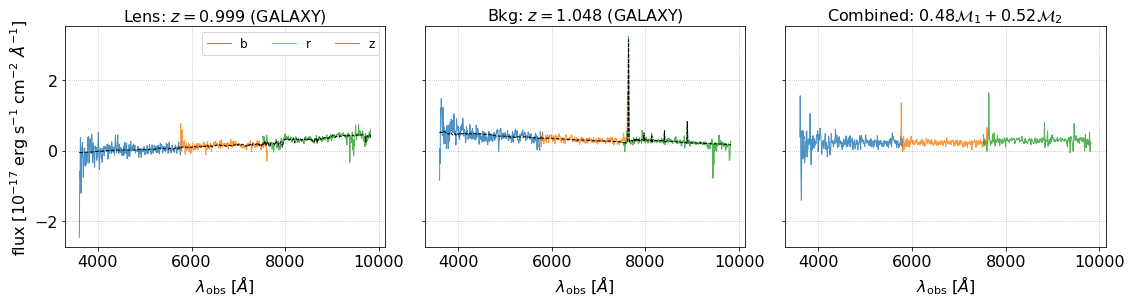

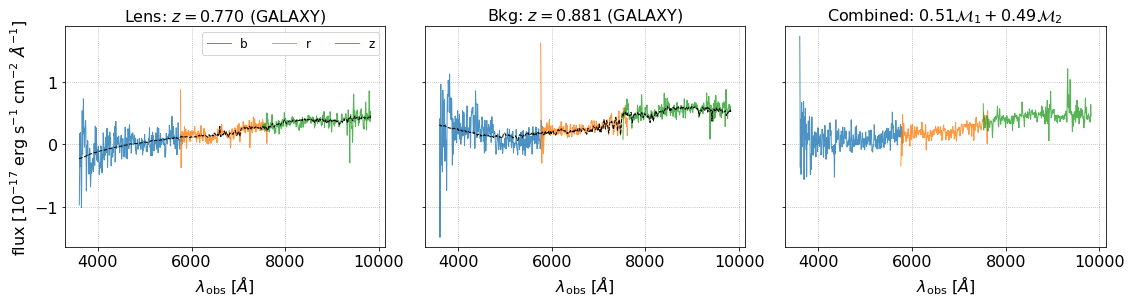

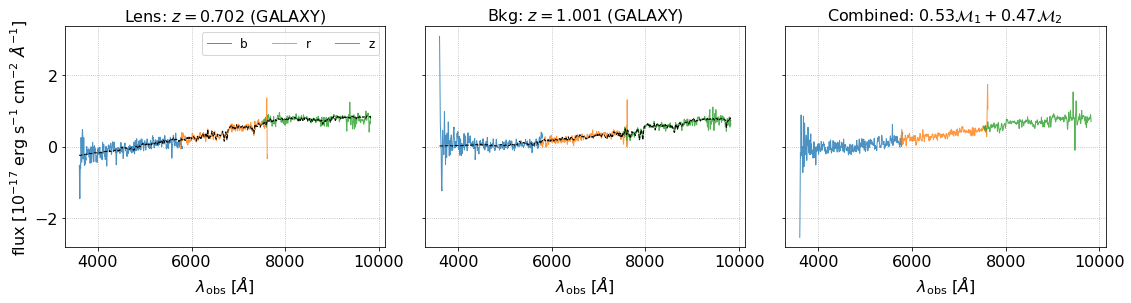

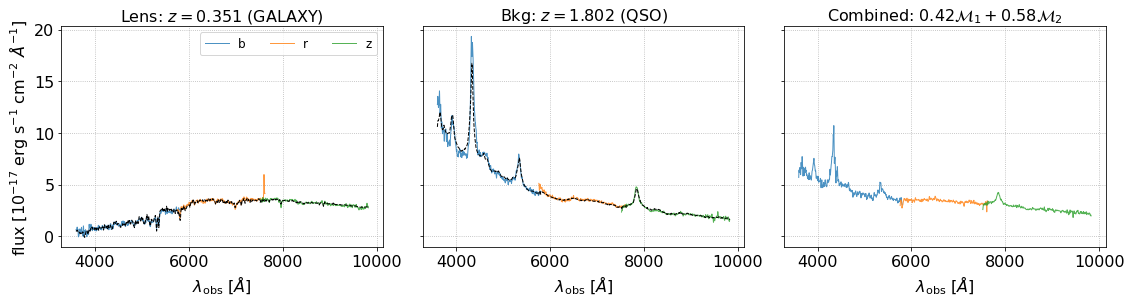

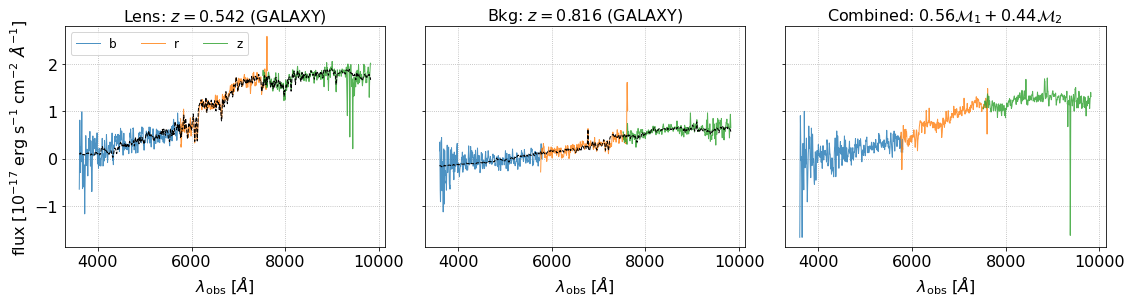

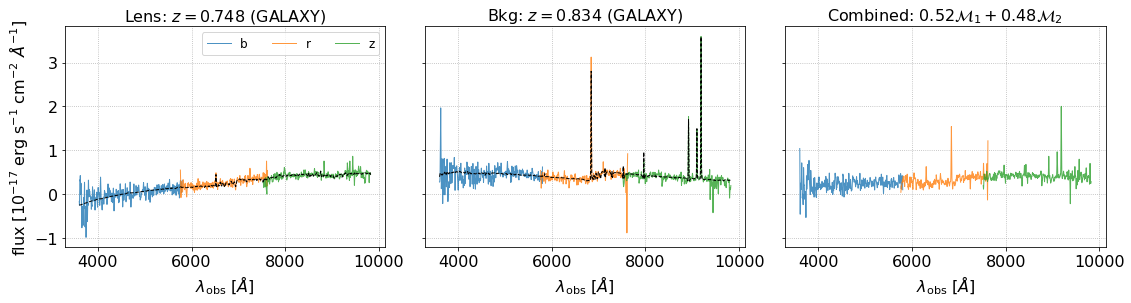

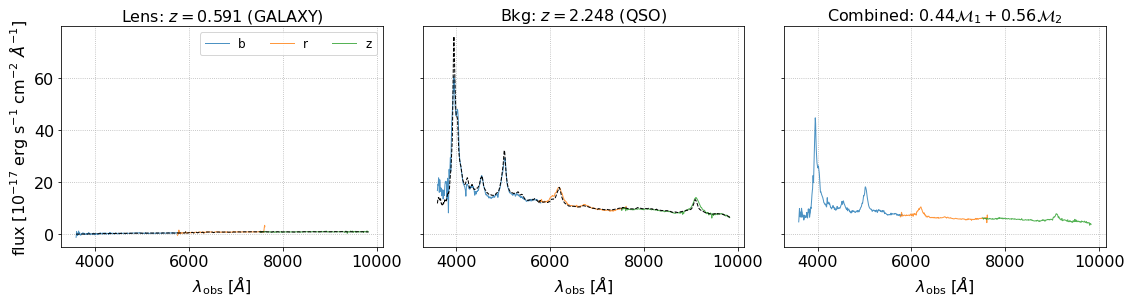

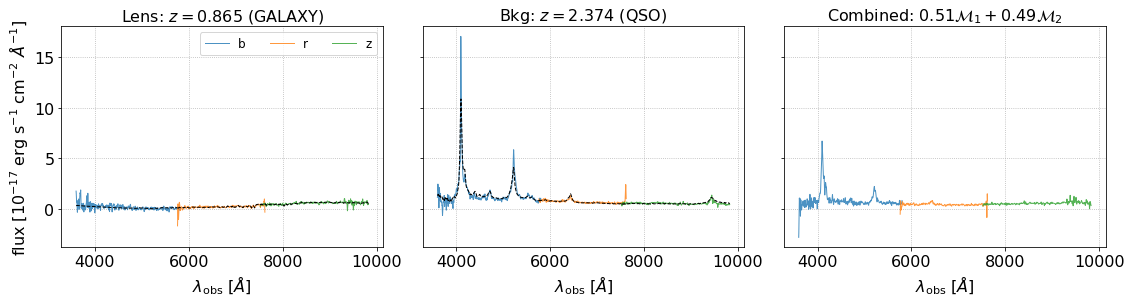

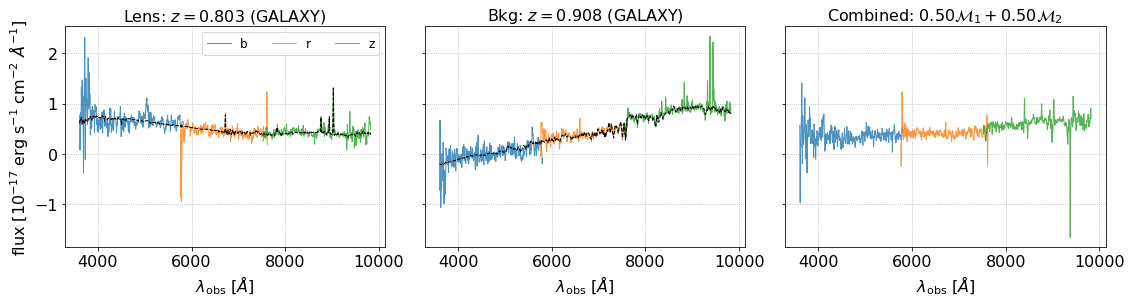

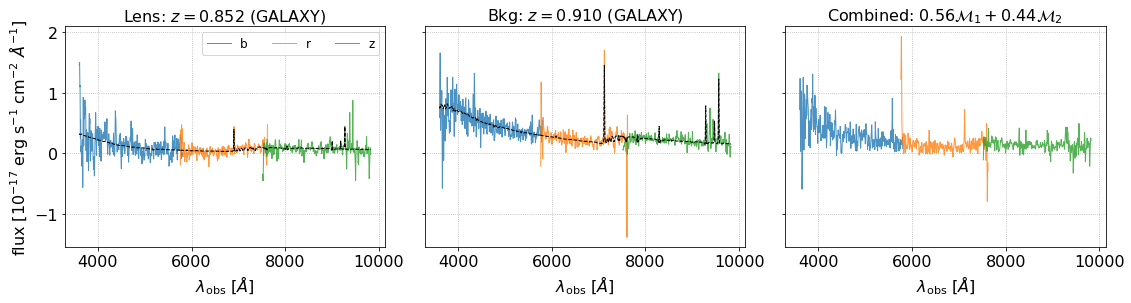

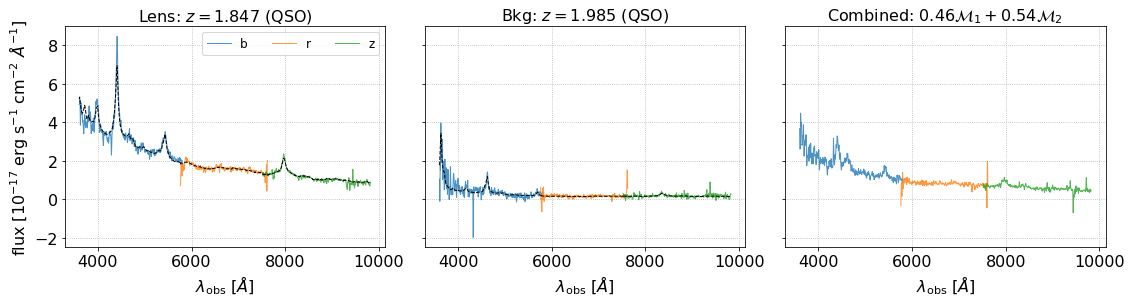

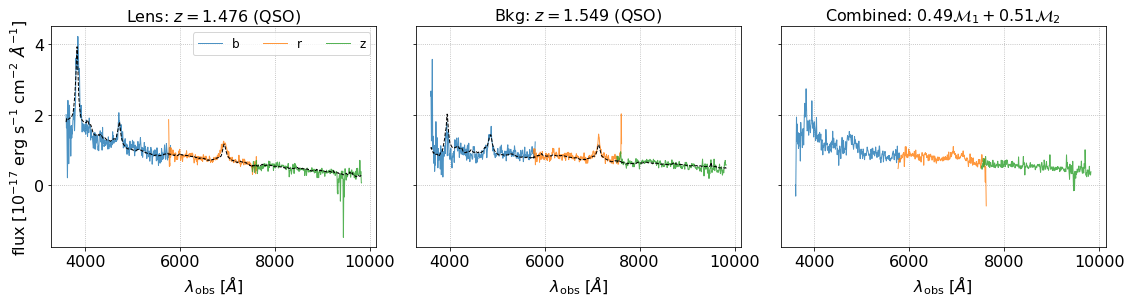

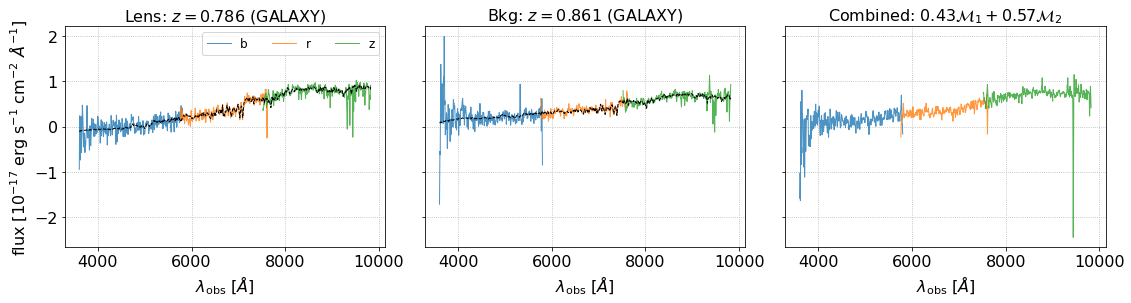

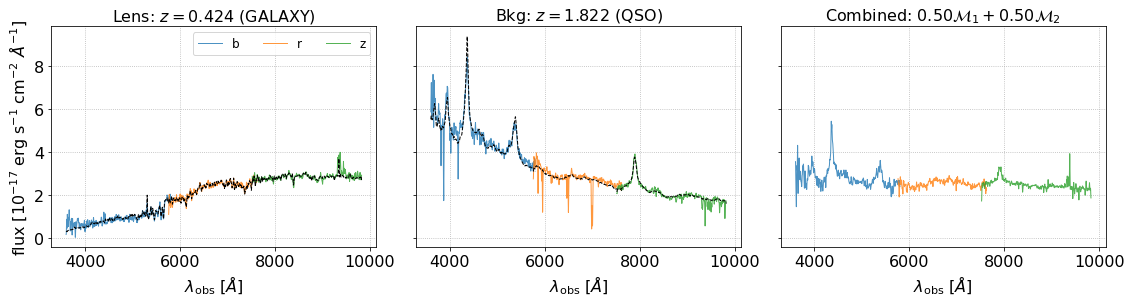

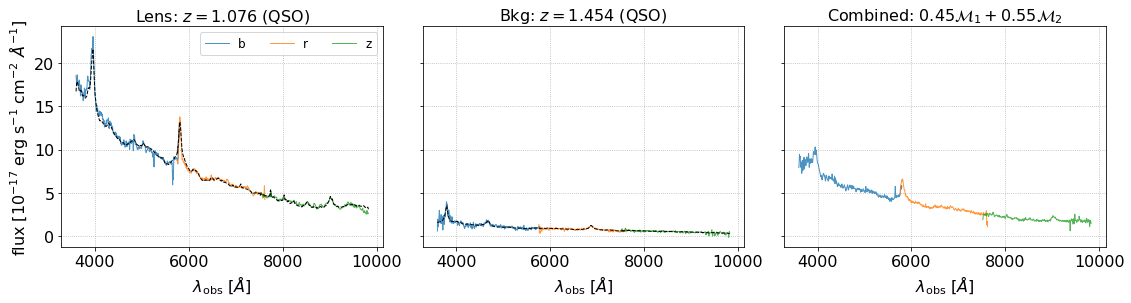

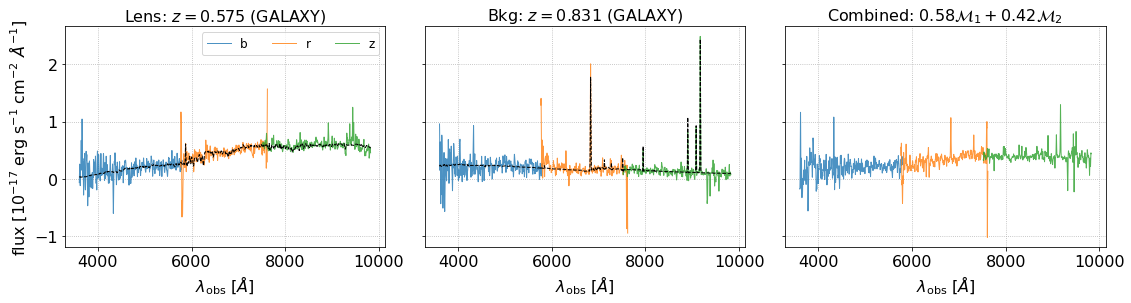

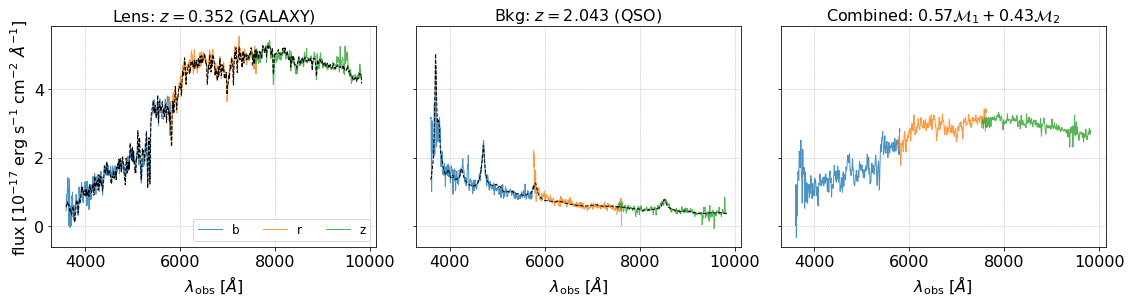

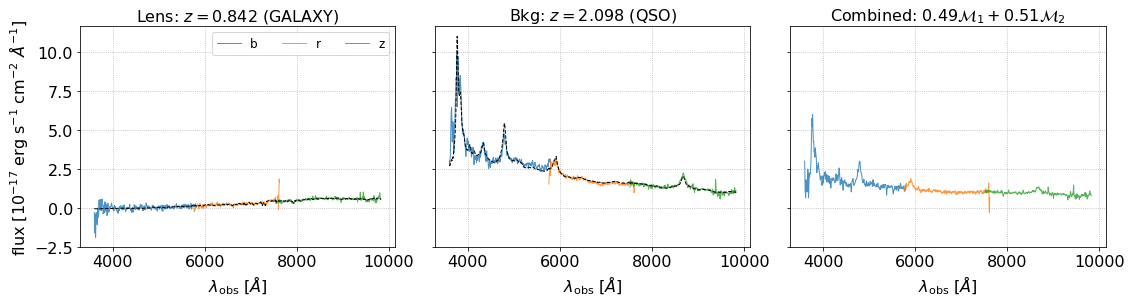

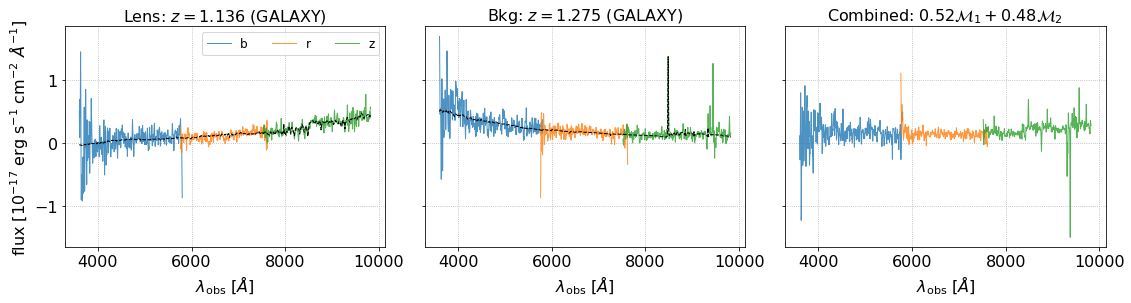

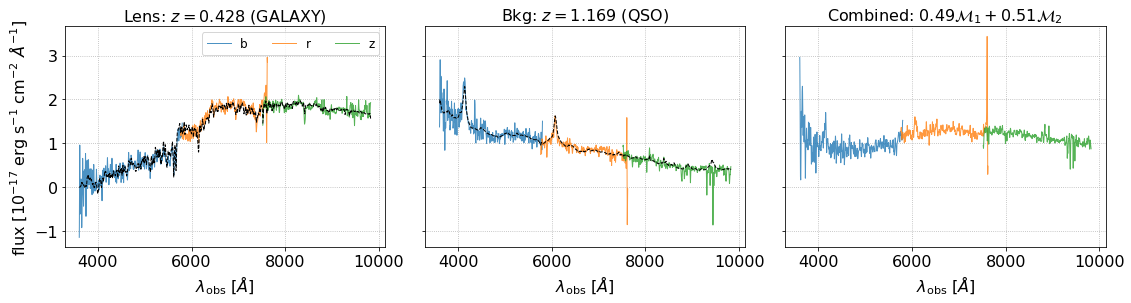

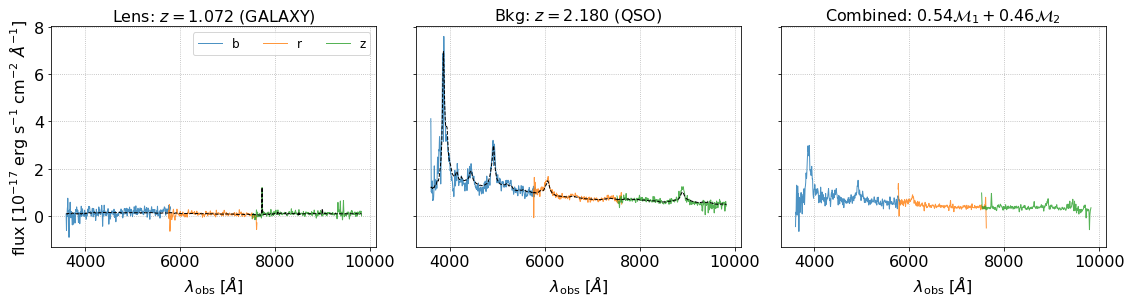

In [25]:
from scipy.ndimage import gaussian_filter1d

fgrspec = read_spectra(fgrfiles[0])
bkgspec = read_spectra(bkgfiles[0])
simspec = read_spectra(lenfiles[0])

alpha = simspec.extra_catalog['ALPHA']
select = np.abs(alpha - 0.5) < 0.1
# select = alpha > 0.8

fgrspec = fgrspec[select]
bkgspec = bkgspec[select]
simspec = simspec[select]

for j in range(fgrspec.num_spectra()):
    
    fig, axes = plt.subplots(1,3, figsize=(16,4.5), sharex=True, sharey=True, tight_layout=True)

    for b in 'brz':
        ax = axes[0]
        smoothed = gaussian_filter1d(fgrspec.flux[b][j], 5)
        ax.plot(fgrspec.wave[b], smoothed, lw=1, alpha=0.8, label=b)
        smoothed = gaussian_filter1d(fgrspec.extra[b]['MODEL'][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls='--')
        ax.set(title='Lens: $z={:.3f}$ ({})'.format(fgrspec.extra_catalog[j]['Z'], fgrspec.extra_catalog[j]['SPECTYPE']),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
               ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
        ax.grid(ls=':')

        ax = axes[1]
        smoothed = gaussian_filter1d(bkgspec.flux[b][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, alpha=0.8)
        smoothed = gaussian_filter1d(bkgspec.extra[b]['MODEL'][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls='--')
        ax.set(title='Bkg: $z={:.3f}$ ({})'.format(bkgspec.extra_catalog[j]['Z'], bkgspec.extra_catalog[j]['SPECTYPE']),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
        ax.grid(ls=':')

        ax = axes[2]
        smoothed = gaussian_filter1d(simspec.flux[b][j], 5)
        ax.plot(simspec.wave[b], smoothed, lw=1, alpha=0.8)
        alpha = simspec.extra_catalog['ALPHA'][j]
        ax.set(title=r'Combined: ${:.2f}\mathcal{{M}}_1 + {:.2f}\mathcal{{M}}_2$'.format(alpha, 1-alpha),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
        ax.grid(ls=':')
        
    ax = axes[0]
    ax.legend(fontsize=12, ncol=3, loc='best')
        
#     fig.savefig('figures/tile{:06d}_synthlens{:03d}.png'.format(tile, j), dpi=120)
    fig.savefig('simlens_{:02d}.png'.format(j), dpi=130)
    if j >= 20:
        break